# Image segmentaion with masked facies

Squish rectangular images to square

Using mask images processed in 01_02_mask_processing

550x550 size

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from fastai.callbacks.tracker import SaveModelCallback
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid
from scipy.stats import mode

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
torch.cuda.set_device(2)

In [5]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: 492f5ad9, DATE: 20191222


In [6]:
#UID='37c69040'
#DATE='20191217'
NB='03_01'

In [7]:
#INFERENCE_MODEL='02_10_0-dfdf95a0_rn34_128-s2-r0-20191222'
INFERENCE_MODEL='02_10_1-be4a9fe2_rn34_256-s2-r0-20191222'

In [8]:
SUBSET_DATA=False
SUBSET_LEN=171

VAL_FILE='val_20pct_0.csv'

TGT_HEIGHT_SMALL = 128
TGT_HEIGHT_MEDIUM = 256
TGT_HEIGHT_FULL = 512

In [9]:
data_dir = Path('../data')
train_images = data_dir/'train_images'
train_path = train_images/'cropped_512/train'
train_mask = train_path/'masks'
train_img = train_path/'images'

test_img = train_images/'cropped_512/test'

preds_path = data_dir/'preds'
preds_path.mkdir(exist_ok=True)



In [10]:
filename = data_dir/'CAX_LogFacies_Train_File.csv'

In [11]:
file_test = data_dir/'CAX_LogFacies_Test_File.csv'

In [12]:
codes = array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'])

#### all data

In [13]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()


,0
0,well_0.png
1,well_1.png
2,well_2.png
3,well_3.png
4,well_4.png


In [14]:
test_df = pd.read_csv(file_test)
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


### Inference

In [15]:
#wd=1e-2
#learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()
#test_data = SegmentationItemList.from_folder(test_img)
#learn=None

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
print(void_code)

def acc_bgvoid(input, target):
    #print(f'in: {input.shape}, tgt: {target.shape}')
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

0


In [17]:
test_img

PosixPath('../data/train_images/cropped_512/test')

In [18]:
test_data = SegmentationItemList.from_folder(test_img)

In [19]:
learn = load_learner(path=train_img, file=f'{INFERENCE_MODEL}.pkl', test=test_data, tfm_y=False, dl_tfms=None)
learn=learn.to_fp16()
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

In [20]:
learn.data.batch_size=8

In [21]:
learn.data.test_ds.tfms

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

In [22]:
#learn.data.test_ds.tfms=None
#learn.data.train_ds.tfms=None
#learn.data.valid_ds.tfms=None

In [23]:
#im = train_images/'cropped/mask_fill/test/cropped/well_5000_GR_crop_0.png'
#img=pil_image.open(im)
#prediction = learn.predict(img)

In [24]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
#preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

tensor(1.0477e+09)


In [25]:
preds.shape

torch.Size([16000, 6, 256, 256])

In [26]:
preds[0].shape

torch.Size([6, 256, 256])

In [27]:
labels = np.argmax(preds, 1)

In [28]:
learn.data.classes

array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'], dtype='<U11')

In [29]:
len(labels)

16000

In [30]:
labels.shape

torch.Size([16000, 256, 256])

As a first pass we want the mode (most common) class for each column in the image

But we want to first ignore background

Lets check a single prediction first

Mult by 40 so can see different colours

In [31]:
npa=labels[0].numpy().astype(np.int32)*40

In [32]:
type(npa[0][0])

numpy.int32

In [33]:
img = pil_image.fromarray(npa)

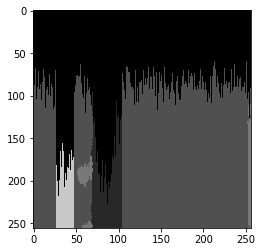

In [34]:
plt.imshow(img)

In [35]:
labels[0].shape

torch.Size([256, 256])

In [36]:
labels.shape

torch.Size([16000, 256, 256])

In [37]:
labels.shape[0]

16000

Example code for calculating median of columns in numpy array but ignoring 0 (background)

<pre>
n=np.array([[0,2,1], [0,1,3], [1,2,3]])
m_mask = n != 0  
new_m = np.where(m_mask, n, np.nan)
m=mode(new_m, axis=0)
r=m[0]
r=r[0].astype(int)
</pre>

In [38]:
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


In [39]:
test_data.items

array([PosixPath('../data/train_images/cropped_512/test/well_5540_crop_2.png'),
       PosixPath('../data/train_images/cropped_512/test/well_5927_crop_6.png'),
       PosixPath('../data/train_images/cropped_512/test/well_5883_crop_5.png'),
       PosixPath('../data/train_images/cropped_512/test/well_5316_crop_1.png'), ...,
       PosixPath('../data/train_images/cropped_512/test/well_5338_crop_7.png'),
       PosixPath('../data/train_images/cropped_512/test/well_6255_crop_6.png'),
       PosixPath('../data/train_images/cropped_512/test/well_5127_crop_5.png'),
       PosixPath('../data/train_images/cropped_512/test/well_6308_crop_7.png')], dtype=object)

In [40]:
#Cropping method - now need to recombine
'''
    images 2200 x 512
    2048 covered in first 4 crops

    def crop_n(img, crop_start):
        #(left, top, right, bottom)
        img_width, img_height = img.size
        
        if crop_start<4:
            cs = crop_start*(img_height)
        elif crop_start==7:
            cs = img_width-img_height
        else:
            cs = int(((crop_start-4)+0.5)*(img_height))
        crop=((cs),0,(cs + img_height), img_height)
        return img.crop(crop)
        
'''

'\n    images 2200 x 512\n    2048 covered in first 4 crops\n\n    def crop_n(img, crop_start):\n        #(left, top, right, bottom)\n        img_width, img_height = img.size\n        \n        if crop_start<4:\n            cs = crop_start*(img_height)\n        elif crop_start==7:\n            cs = img_width-img_height\n        else:\n            cs = int(((crop_start-4)+0.5)*(img_height))\n        crop=((cs),0,(cs + img_height), img_height)\n        return img.crop(crop)\n        \n'

In [41]:
def get_well_list(test_data):
    ids=[]
    for f in test_data:
        id=f.name.split('_')[1]
        ids.append(id)
    return ids

In [42]:
v=test_data.items.tolist()
well_ds=get_well_list(v)

In [43]:
len(well_ds)

16000

In [44]:
labels.shape[0]

16000

In [45]:
labels[0].shape

torch.Size([256, 256])

In [46]:
len(test_data.items)

16000

### Coerce the predictions

Next we take each image and take the mode (most common prediction) of y for each x to get the overall facies prediction at that x (where x = depth, y = facies pred)

In [47]:
#### free memory

In [48]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('training_data', 447579160),
 ('test_df', 201289050),
 ('all_wells_df', 279050),
 ('npa', 262256),
 ('well_ds', 140592),
 ('v', 128072),
 ('wells', 32096),
 ('fastai_types', 2288),
 ('DataLoader', 1472),
 ('EmptyLabelList', 1472),
 ('ImageDataBunch', 1472),
 ('Learner', 1472),
 ('SegmentationItemList', 1472),
 ('SegmentationLabelList', 1472),
 ('progress_bar', 1472),
 ('FlattenedLoss', 1192),
 ('LabelList', 1192),
 ('OptimWrapper', 1192),
 ('Recorder', 1192),
 ('Series', 1192),
 ('TfmAffine', 1192),
 ('TfmCoord', 1192),
 ('TfmCrop', 1192),
 ('TfmLighting', 1192),
 ('AUROC', 1064),
 ('AccumulateScheduler', 1064),
 ('AdaptiveConcatPool2d', 1064),
 ('AffineMatrix', 1064),
 ('AverageMetric', 1064),
 ('BatchNorm1dFlat', 1064),
 ('BatchSampler', 1064),
 ('BnFreeze', 1064),
 ('Callback', 1064),
 ('CallbackHandler', 1064),
 ('Category', 1064),
 ('CategoryList', 1064),
 ('CategoryProcessor', 1064),
 ('ClassificationInterpretation', 1064),
 ('Config', 1064),
 ('ConfusionMatrix', 1064),
 ('Coun

In [49]:
learn=None
preds = None
training_data = None
test_df = None
all_wells_df = None
npa = None
well_ds = None
v = None
wells = None

In [50]:
gc.collect()

55

In [51]:
import os
import psutil
pid = os.getpid()
py = psutil.Process(pid)

In [52]:
def calc_mode_on_cols(labels,image_files):
    print(f'len(data): {len(image_files)}, labels.shape[0]: {labels.shape[0]}')
    frames=[]
    for i, f in enumerate(image_files):
        memoryUse = py.memory_info()[0] / 2. ** 30
        if i==0:
           print(f'starting memory use: {memoryUse}') 
        elif memoryUse>86.0:
            print(f'killing process at image {i}, memory use: {memoryUse}')
            break
        name=f.name.split('.png')[0]
        well_id=name.split('_crop_')[0]
        crop_idx=name.split('_crop_')[1]
        row_ids=range(len(labels[i]))
        n=labels[i]
        m_mask = n != 0  
        new_m = np.where(m_mask, n, np.nan)
        m=mode(new_m, axis=0)
        r=m[0].flatten().astype(int)
        well_col=[well_id] * len(n)
        crop_col=[crop_idx] * len(n)
        tdf = pd.DataFrame({'row_id': row_ids, 'facies': r,
                            'well_id': well_col, 'crop_idx': crop_col})
        frames.append(tdf)
    memoryUse = py.memory_info()[0] / 2. ** 30
    print(f'end memory use: {memoryUse}')
    df = pd.concat(frames)
    return df

Run this in parts so dont use all memory

In [53]:
#df=calc_mode_on_cols(labels[:4000],test_data.items[:4000])
df=calc_mode_on_cols(labels,test_data.items)

len(data): 16000, labels.shape[0]: 16000
starting memory use: 35.984317779541016
end memory use: 35.984615325927734


In [54]:
df.head()

,row_id,facies,well_id,crop_idx
0,0,2,well_5540,2
1,1,2,well_5540,2
2,2,2,well_5540,2
3,3,2,well_5540,2
4,4,2,well_5540,2


In [55]:
INFERENCE_MODEL

'02_10_1-be4a9fe2_rn34_256-s2-r0-20191222'

In [56]:
df.to_csv(preds_path/f'{INFERENCE_MODEL}.csv')

In [57]:
len(df)

4096000

In [58]:
df.tail()

,row_id,facies,well_id,crop_idx
251,251,2,well_6308,7
252,252,2,well_6308,7
253,253,2,well_6308,7
254,254,2,well_6308,7
255,255,2,well_6308,7


In [59]:
df = df.sort_values(by=['well_id', 'row_id'])

In [60]:
df.head()

,row_id,facies,well_id,crop_idx
0,0,2,well_5000,7
0,0,2,well_5000,6
0,0,2,well_5000,0
0,0,2,well_5000,5
0,0,4,well_5000,3
